# Tutorial

This tutorial implements the sigmoid nonlinear multivariate Hawkes processes in ***"Efficient Inference for Dynamic Flexible Interactions of Neural Populations"***. It includes both simulation and statistical inference. 

## Multivariate Hawkes Processes

The vanilla multivariate Hawkes processes are sequences of timestamps $D=\{\{t_n^i \}_{n=1}^{N_i}\}_{i=1}^M\in[0,T]$ where $t_n^i$ is the timestamp of $n$-th event on $i$-th dimension with $N_i$ being the number of points on $i$-th dimension, $M$ the number of dimensions, $T$ the observation window. The $i$-th dimensional conditional intensity, the probability of an event occurring on $i$-th dimension in $[t,t+dt)$ given all dimensional history before $t$, is designed in a linear superposition form:

$$\lambda_i(t)=\mu_i+\sum_{j=1}^M\sum_{t_n^j<t}\phi_{ij}(t-t_n^j),$$

where $\mu_i>0$ is the baseline rate of $i$-th dimension and $\phi_{ij}(\cdot)\geq0$ is the causal influence function from $j$-th dimension to $i$-th dimension which is normally a parameterized function, e.g., exponential decay. The summation explains the self- and mutual-excitation phenomenon, i.e., the occurrence of previous events increases the intensity of events in the future. Unfortunately, one blemish is the vanilla multivariate Hawkes processes allow only nonnegative (excitatory) influence functions because negative (inhibitory) influence functions may yield a negative intensity which is meaningless.

## Sigmoid Nonlinear Multivariate Hawkes Processes

To reconcile the vanilla version with inhibitory effect and flexible influence function, we propose the SNMHP. Similar to the classic nonlinear multivariate Hawkes processes, the $i$-th dimensional conditional intensity of SNMHP is defined as

$$\lambda_i(t)=\overline{\lambda}_i\sigma(h_i(t)),\ \ \ h_i(t)=\mu_i+\sum_{j=1}^M\sum_{t_n^j<t}\phi_{ij}(t-t_n^j),$$

where $\mu_i$ is the base activation of dimension $i$, $h_i(t)$ is a real-valued activation and $\sigma(\cdot)$ is the logistic (sigmoid) function which maps the activation into a positive real value in $(0,1)$ with $\overline{\lambda}_i$ being a upper-bound to scale it to $(0,\overline{\lambda}_i)$. The sigmoid function is chosen because the P\'{o}lya-Gamma augmentation scheme can be utilized to make the inference tractable.

To achieve a flexible influence function, the influence function is assumed to be a weighted sum of basis functions

$$\phi_{ij}(\cdot)=\sum_{b=1}^B w_{ijb}\tilde{\phi}_b(\cdot),$$

where $\{\tilde{\phi}_b\}_{b=1}^B$ are predefined basis functions and $w_{ijb}$ is the weight capturing the influence from $j$-th dimension to $i$-th dimension by $b$-th basis function with positive indicating excitation and negative indicating inhibition. Although basis functions can be in any form, in order for the weights to represent functional connection strength, basis functions are chosen to be probability densities with compact support that means they have bounded support $[0,T_\phi]$ and the integral is one. As a result, the $i$-th dimensional activation is 

$$h_i(t)=\mu_i+\sum_{j=1}^M\sum_{t_n^j<t}\sum_{b=1}^B w_{ijb}\tilde{\phi}_{b}(t-t_n^j)=\mu_i+\sum_{j=1}^M\sum_{b=1}^B w_{ijb}\sum_{t_n^j<t}\tilde{\phi}_{b}(t-t_n^j)=\mu_i+\sum_{j=1}^M\sum_{b=1}^B w_{ijb}\Phi_{jb}(t)=\mathbf{w}_{i}^T\cdot\mathbf{\Phi}(t),$$

where $\Phi_{jb}(t)$ is the convolution of $j$-th dimensional observation with $b$-th basis function and can be precomputed; $\mathbf{w}_{i}=[\mu_i, w_{i11},\dotsc, w_{iMB}]^T$ and $\mathbf{\Phi}(t)=[1, \Phi_{11}(t), \dotsc, \Phi_{MB}(t)]^T$, both are $(MB+1)\times1$ vectors. Here, the basis functions are scaled (shifted) Beta densities, but alternatives such as Gaussian or Gamma also can be used. 

### Simulation

From the `snm_hawkes_beta` module, we import the `SNMHawkesBeta` class. We set the number of dimensions and basis functions. We initialise an instance of a 2D sigmoid nonlinear multivariate Hawkes processes.

In [62]:
import random
import numpy as np
import pandas as pd
import seaborn as sns # for plot
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False}) # set seaborn style
import matplotlib.pyplot as plt # for plot
from importlib import reload
import snm_hawkes_beta
snm_hawkes_beta = reload(snm_hawkes_beta)
from snm_hawkes_beta import SNMHawkesBeta
from scipy.stats import beta
from scipy.stats import multivariate_normal
from scipy.stats import gamma

In [63]:
number_of_dimensions=2
number_of_basis=4
toy_model = SNMHawkesBeta(number_of_dimensions,number_of_basis)

We input the parameters: the intensity upperbound $\bar{\lambda}=[5,5]$, the base activation $\mu=[0,0]$, the parameters of basis functions (beta densities) are $\text{Beta}(a=50,b,=50,\text{shift}=\{-2,-1,0,1\})$, the influence weight $W=[[[1,0,0,0],[0,-0.5,0,0]],[[0,0,0,-0.5],[0,0,1,0]]]$ and the support of influence function (the scale of basis functions) $T_\phi=6$.

In [64]:
beta_ab=np.array([[50,50,-2],[50,50,-1],[50,50,0],[50,50,1]])
T_phi=6.
T=400.
lamda_ub=np.array([5.,5.])
base_activation=np.array([0.,0.])
weight=np.array([[[1.,0,0,0],[0,-0.5,0,0]],[[0,0,0,-0.5],[0,0,1.,0]]])

In [65]:
toy_model.set_hawkes_hyperparameters(beta_ab, T_phi)
toy_model.set_hawkes_parameters(lamda_ub, base_activation, weight)

We simulate two sets of data as the training/test data. Both the training and test datasets are on $[0,T]$. `points_hawkes` and `points_hawkes_test` are the timestamps on each dimension for training and test data. You can simulate the synthetic data or load our synthetic data directly.

In [66]:
# # simulation
# points_hawkes = toy_model.simulation(T)
# points_hawkes_test = toy_model.simulation(T)

In [5]:
# load our synthetic data
df=pd.read_csv('./synthetic_data.csv',index_col=0)
points_hawkes=[]
for i in range(2):
    points_hawkes.append(list(df.iloc[i].values[~np.isnan(df.iloc[i].values)]))

df=pd.read_csv('./synthetic_data_test.csv',index_col=0)
points_hawkes_test=[]
for i in range(2):
    points_hawkes_test.append(list(df.iloc[i].values[~np.isnan(df.iloc[i].values)]))

Let us visualize the simulated data. 

In [7]:
intensity_train=[[toy_model.intensity(t, 0, points_hawkes) for t in np.linspace(0,20,1000)],[toy_model.intensity(t, 1, points_hawkes) for t in np.linspace(0,20,1000)]]
intensity_test=[[toy_model.intensity(t, 0, points_hawkes_test) for t in np.linspace(0,20,1000)],[toy_model.intensity(t, 1, points_hawkes_test) for t in np.linspace(0,20,1000)]]

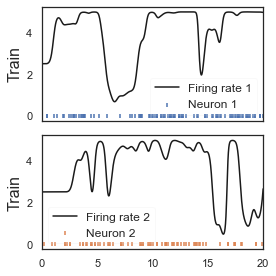

In [21]:
f, axes = plt.subplots(2, 1,figsize=(4,4),sharex=True, gridspec_kw={'height_ratios': [2,2]})
sns.set(style="white")

i_points=np.array(points_hawkes[0])
axes[0].scatter(i_points,[0]*len(i_points),s=10,c=np.array([sns.color_palette()[0]]),marker='|',label='Neuron 1')
axes[0].plot(np.linspace(0,20,1000),intensity_train[0],color='k',label='Firing rate 1')
axes[0].set_ylabel('Train',fontsize=16)
axes[0].legend(fontsize=12,framealpha=0.1,loc='best')
axes[0].ticklabel_format(style='plain', axis='x', scilimits=(0,0))
axes[0].set_xlim(0,20)

i_points=np.array(points_hawkes[1])
axes[1].scatter(i_points,[0]*len(i_points),s=10,c=np.array([sns.color_palette()[1]]),marker='|',label='Neuron 2')
axes[1].plot(np.linspace(0,20,1000),intensity_train[1],color='k',label='Firing rate 2')
axes[1].set_ylabel('Train',fontsize=16)
axes[1].legend(fontsize=12,framealpha=0.1,loc='best')
axes[1].ticklabel_format(style='plain', axis='x', scilimits=(0,0))
axes[1].set_xlim(0,20)

plt.tight_layout()
plt.show()

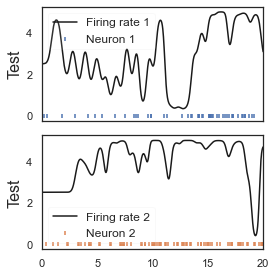

In [20]:
f, axes = plt.subplots(2, 1,figsize=(4,4),sharex=True, gridspec_kw={'height_ratios': [2,2]})
sns.set(style="white")

i_points=np.array(points_hawkes_test[0])
axes[0].scatter(i_points,[0]*len(i_points),s=10,c=np.array([sns.color_palette()[0]]),marker='|',label='Neuron 1')
axes[0].plot(np.linspace(0,20,1000),intensity_test[0],color='k',label='Firing rate 1')
axes[0].set_ylabel('Test',fontsize=16)
axes[0].legend(fontsize=12,framealpha=0.1,loc='best')
axes[0].ticklabel_format(style='plain', axis='x', scilimits=(0,0))
axes[0].set_xlim(0,20)

i_points=np.array(points_hawkes_test[1])
axes[1].scatter(i_points,[0]*len(i_points),s=10,c=np.array([sns.color_palette()[1]]),marker='|',label='Neuron 2')
axes[1].plot(np.linspace(0,20,1000),intensity_test[1],color='k',label='Firing rate 2')
axes[1].set_ylabel('Test',fontsize=16)
axes[1].legend(fontsize=12,framealpha=0.1,loc='best')
axes[1].ticklabel_format(style='plain', axis='x', scilimits=(0,0))
axes[1].set_xlim(0,20)

plt.tight_layout()
plt.show()

### Inference: Gibbs Sampler

We perform inference using Gibbs sampler. The input arguments are training data: `points_hawkes`, test data: `points_hawkes_test`, the end time of training data: `T` and test data: `T_test`, the "variance" of the Laplace prior: `b`, the number of grids `num_grid` on \[0,T\] and `num_grid_test` on \[0,T_test\], the number of iterations: `num_iter`. It runs about 10 mins on my laptop. 

In [14]:
%%time
np.random.seed(10)
lamda_ub_list_gibbs,W_list_gibbs,logl_gibbs,logl_test_gibbs = \
toy_model.Gibbs_inference(points_hawkes, points_hawkes_test,\
            T=400., T_test=400., b=0.2, num_grid=2000, num_grid_test=2000, num_iter=200)

CPU times: user 14min 4s, sys: 1min 54s, total: 15min 59s
Wall time: 9min 38s


The output `lamda_ub_list_gibbs` is the samples of intensity upperbounds, `W_list_gibbs[:,:,0]` is the samples of base activation, `W_list_gibbs[:,:,1:]` is the samples of influence weight, `logl_gibbs` and `logl_test_gibbs` are the training and test log-likelihood along Gibbs loops. 

We evaluate the mean of parameters by the last 100 samples. 

In [15]:
lamda_ub_gibbs_mean=np.mean(lamda_ub_list_gibbs[-100:],axis=0)
W_gibbs_mean=np.mean(W_list_gibbs[-100:],axis=0)

Let us visualize the estimated influence functions $\hat{\phi}_{ij}$ where $i$ is the target dimension, $j$ is the source dimension. 

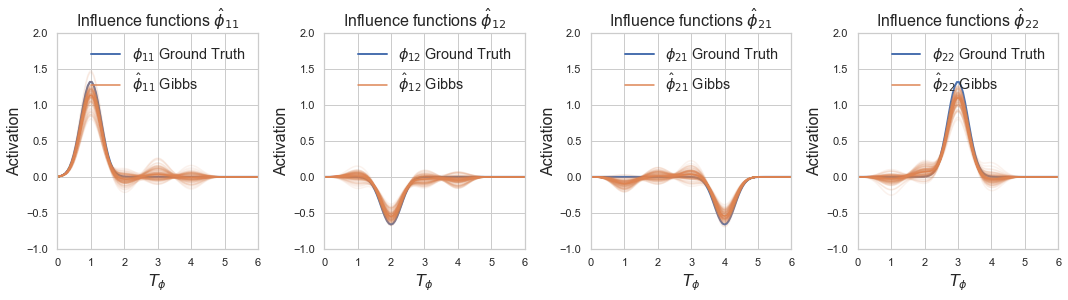

In [23]:
sns.set_style("whitegrid")
fig=plt.figure(1,figsize=(15,7.5))
for i in range(len(points_hawkes)):
    for j in range(len(points_hawkes)):
        axs=fig.add_subplot(2,4,i*2+j*1+1)
        axs.plot(np.linspace(0,T_phi,100),toy_model.influence_function_estimated\
                 (i,j,np.linspace(0,T_phi,100),gt=True),linewidth=2,label='$\phi_{%s%s}$ Ground Truth'%(i+1,j+1))
        for k in range(100):
            toy_model.set_hawkes_parameters_estimated(lamda_ub_list_gibbs[-1-k], W_list_gibbs[-1-k])
            axs.plot(np.linspace(0,T_phi,100),toy_model.influence_function_estimated\
                 (i,j,np.linspace(0,T_phi,100)),color=sns.color_palette()[1],alpha=0.1)
        toy_model.set_hawkes_parameters_estimated(lamda_ub_gibbs_mean, W_gibbs_mean)
        axs.plot(np.linspace(0,T_phi,100),toy_model.influence_function_estimated\
                 (i,j,np.linspace(0,T_phi,100)),color=sns.color_palette()[1],label='$\hat{\phi}_{%s%s}$ Gibbs'%(i+1,j+1))
        plt.legend(ncol=1,loc='upper right',frameon=False,fontsize='large')
        plt.xlabel('$T_{\phi}$',fontsize=16)
        plt.ylabel('Activation',fontsize=16)
        plt.xlim(0,6)
        plt.ylim(-1,2)
        plt.title('Influence functions $\hat{\phi}_{%s%s}$'%(i+1,j+1),fontsize=16)
plt.tight_layout()
plt.show()

### Inference: EM Algorithm

We perform inference using EM algorithm. The input arguments are training data: `points_hawkes`, test data: `points_hawkes_test`, the end time of training data: `T` and test data: `T_test`, the "variance" of the Laplace prior: `b`, the number of Gaussian quadrature nodes `num_gq` on \[0,T\] and `num_gq_test` on \[0,T_test\], the number of iterations: `num_iter`. It runs about 30 secs on my laptop. 

In [24]:
%%time
np.random.seed(10)
lamda_ub_em,W_em,logl_em,logl_test_em = \
toy_model.EM_inference(points_hawkes, points_hawkes_test,\
            T=400., T_test=400., b=0.2, num_gq=2000, num_gq_test=2000, num_iter=200)

CPU times: user 43.4 s, sys: 2.69 s, total: 46.1 s
Wall time: 32.9 s


The output `lamda_ub_em` is the estimated intensity upperbounds, `W_em[:,0]` is the estimated base activation, `W_em[:,1:]` is the estimated influence weight, `logl_em` and `logl_test_em` are the training and test log-likelihood along EM iterations.

Let us visualize the estimated influence functions $\hat{\phi}_{ij}$. 

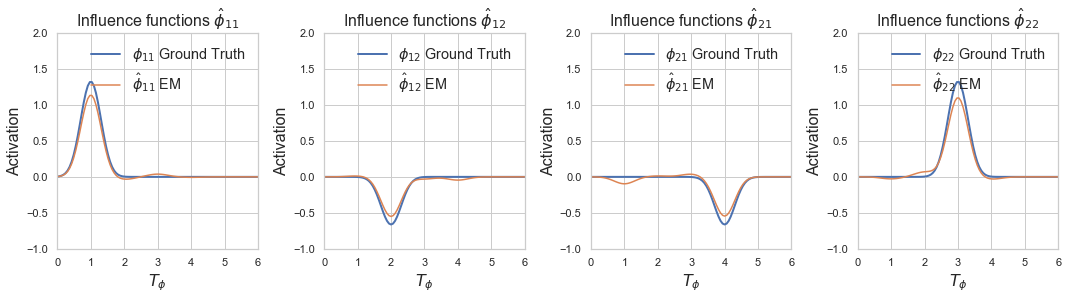

In [25]:
sns.set_style("whitegrid")
fig=plt.figure(1,figsize=(15,7.5))
for i in range(len(points_hawkes)):
    for j in range(len(points_hawkes)):
        axs=fig.add_subplot(2,4,i*2+j*1+1)
        axs.plot(np.linspace(0,T_phi,100),toy_model.influence_function_estimated\
                 (i,j,np.linspace(0,T_phi,100),gt=True),linewidth=2,label='$\phi_{%s%s}$ Ground Truth'%(i+1,j+1))
        axs.plot(np.linspace(0,T_phi,100),toy_model.influence_function_estimated\
                 (i,j,np.linspace(0,T_phi,100)),color=sns.color_palette()[1],label='$\hat{\phi}_{%s%s}$ EM'%(i+1,j+1))
        plt.legend(ncol=1,loc='upper right',frameon=False,fontsize='large')
        plt.xlabel('$T_{\phi}$',fontsize=16)
        plt.ylabel('Activation',fontsize=16)
        plt.xlim(0,6)
        plt.ylim(-1,2)
        plt.title('Influence functions $\hat{\phi}_{%s%s}$'%(i+1,j+1),fontsize=16)
plt.tight_layout()
plt.show()

### Inference: Mean-field Approximation

We perform inference using mean-field approximation. The input arguments are training data: `points_hawkes`, test data: `points_hawkes_test`, the end time of training data: `T` and test data: `T_test`, the "variance" of the Laplace prior: `b`, the number of Gaussian quadrature nodes `num_gq` on \[0,T\] and `num_gq_test` on \[0,T_test\], the number of iterations: `num_iter`. It runs about 40 secs on my laptop. 

In [27]:
%%time
np.random.seed(10)
alpha_mf, mean_W_mf, cov_W_mf, logl_mf, logl_test_mf = \
toy_model.MF_inference(points_hawkes, points_hawkes_test,\
                T=400., T_test=400., b=0.2, num_gq=2000, num_gq_test=2000, num_iter=200)

CPU times: user 54.9 s, sys: 2.62 s, total: 57.5 s
Wall time: 44.6 s


The output `alpha_mf/T` is the estimated mean intensity upperbounds, `mean_W_mf[:,0]` is the estimated mean base activation, `mean_W_mf[:,1:]` is the estimated mean influence weight, `cov_W_mf` is the estimated covariance of weights, `logl_mf` and `logl_test_mf` are the training and test log-likelihood along MF iterations by the mean. 

We draw 100 samples from the posterior of these parameters for the following plot.

In [29]:
W_mf_samples=np.zeros((100,mean_W_mf.shape[0],mean_W_mf.shape[1]))
for i in range(100):
    for d in range(mean_W_mf.shape[0]):
        W_mf_samples[i][d]=multivariate_normal(mean_W_mf[d],cov_W_mf[d]).rvs()
lamda_up_mf_samples=np.zeros((100,mean_W_mf.shape[0]))
for i in range(100):
    lamda_up_mf_samples[i]=gamma(a=alpha_mf,scale=1/T).rvs()

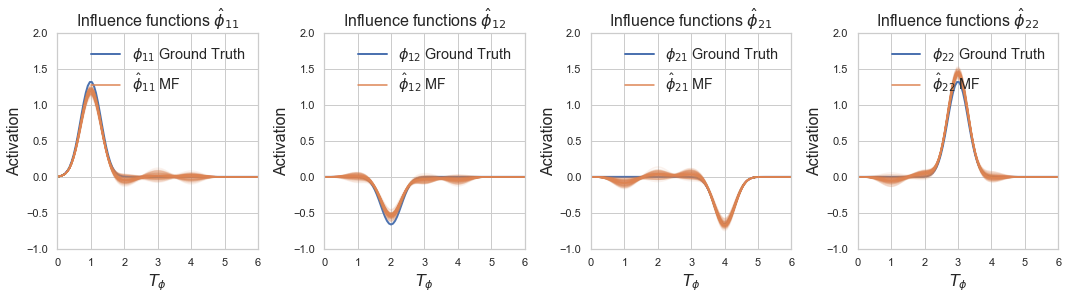

In [30]:
sns.set_style("whitegrid")
fig=plt.figure(1,figsize=(15,7.5))
for i in range(len(points_hawkes)):
    for j in range(len(points_hawkes)):
        axs=fig.add_subplot(2,4,i*2+j*1+1)
        axs.plot(np.linspace(0,T_phi,100),toy_model.influence_function_estimated\
                 (i,j,np.linspace(0,T_phi,100),gt=True),linewidth=2,label='$\phi_{%s%s}$ Ground Truth'%(i+1,j+1))
        for k in range(100):
            toy_model.set_hawkes_parameters_estimated(lamda_up_mf_samples[-1-k], W_mf_samples[-1-k])
            axs.plot(np.linspace(0,T_phi,100),toy_model.influence_function_estimated\
                 (i,j,np.linspace(0,T_phi,100)),color=sns.color_palette()[1],alpha=0.1)
        toy_model.set_hawkes_parameters_estimated(alpha_mf/T, mean_W_mf)
        axs.plot(np.linspace(0,T_phi,100),toy_model.influence_function_estimated\
                 (i,j,np.linspace(0,T_phi,100)),color=sns.color_palette()[1],label='$\hat{\phi}_{%s%s}$ MF'%(i+1,j+1))
        plt.legend(ncol=1,loc='upper right',frameon=False,fontsize='large')
        plt.xlabel('$T_{\phi}$',fontsize=16)
        plt.ylabel('Activation',fontsize=16)
        plt.xlim(0,6)
        plt.ylim(-1,2)
        plt.title('Influence functions $\hat{\phi}_{%s%s}$'%(i+1,j+1),fontsize=16)
plt.tight_layout()
plt.show()

Let us visualize the log-likelihood curves along iterations for three different algorithms. 

In [44]:
training_gibbs=pd.DataFrame(np.array([np.arange(0,len(logl_gibbs)),logl_gibbs]).T,columns=['Iterations','Log-likelihood'])
training_gibbs['Dataset']='Training'
test_gibbs=pd.DataFrame(np.array([np.arange(0,len(logl_test_gibbs)),logl_test_gibbs]).T,columns=['Iterations','Log-likelihood'])
test_gibbs['Dataset']='Test'
loglikelihood_gibbs=pd.concat([training_gibbs,test_gibbs])
loglikelihood_gibbs['Algorithm']='Gibbs'

training_em=pd.DataFrame(np.array([np.arange(0,len(logl_em)),logl_em]).T,columns=['Iterations','Log-likelihood'])
training_em['Dataset']='Training'
test_em=pd.DataFrame(np.array([np.arange(0,len(logl_test_em)),logl_test_em]).T,columns=['Iterations','Log-likelihood'])
test_em['Dataset']='Test'
loglikelihood_em=pd.concat([training_em,test_em])
loglikelihood_em['Algorithm']='EM'

training_mf=pd.DataFrame(np.array([np.arange(0,len(logl_mf)),logl_mf]).T,columns=['Iterations','Log-likelihood'])
training_mf['Dataset']='Training'
test_mf=pd.DataFrame(np.array([np.arange(0,len(logl_test_mf)),logl_test_mf]).T,columns=['Iterations','Log-likelihood'])
test_mf['Dataset']='Test'
loglikelihood_mf=pd.concat([training_mf,test_mf])
loglikelihood_mf['Algorithm']='MF'

loglikelihood_curve=pd.concat([loglikelihood_gibbs,loglikelihood_mf,loglikelihood_em],ignore_index=True)

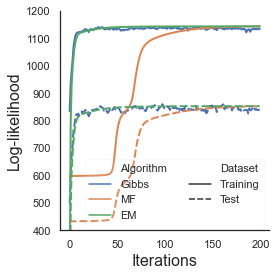

In [45]:
f, axes = plt.subplots(1, 1,figsize=(4,4))
sns.set(style='white')
sns.despine()
sns.lineplot(x='Iterations', y='Log-likelihood',hue='Algorithm',style='Dataset',\
             dashes=True,linewidth = 2, data=loglikelihood_curve,ax=axes)
axes.legend(fontsize=11,framealpha=0.1,ncol=2,loc='best')
axes.set_xlabel("Iterations",fontsize=16)
axes.set_ylabel("Log-likelihood",fontsize=16)
axes.set_ylim(400,1200)
plt.tight_layout()
plt.show()

Let us visualize the heat map of functional connectivity between two neurons with red indicating excitation and
blue indicating inhibition. 

In [46]:
phi_heat_gt=np.array([[1,-0.5],[-0.5,1]])
phi_heat_gibbs=np.zeros((number_of_dimensions,number_of_dimensions))
for i in range(number_of_dimensions):
    phi_heat_gibbs[:,i]=np.sum(W_gibbs_mean[:,1:][:,number_of_basis*i:number_of_basis*(i+1)],axis=1)
phi_heat_em=np.zeros((number_of_dimensions,number_of_dimensions))
for i in range(number_of_dimensions):
    phi_heat_em[:,i]=np.sum(W_em[:,1:][:,number_of_basis*i:number_of_basis*(i+1)],axis=1)
phi_heat_mf=np.zeros((number_of_dimensions,number_of_dimensions))
for i in range(number_of_dimensions):
    phi_heat_mf[:,i]=np.sum(mean_W_mf[:,1:][:,number_of_basis*i:number_of_basis*(i+1)],axis=1)

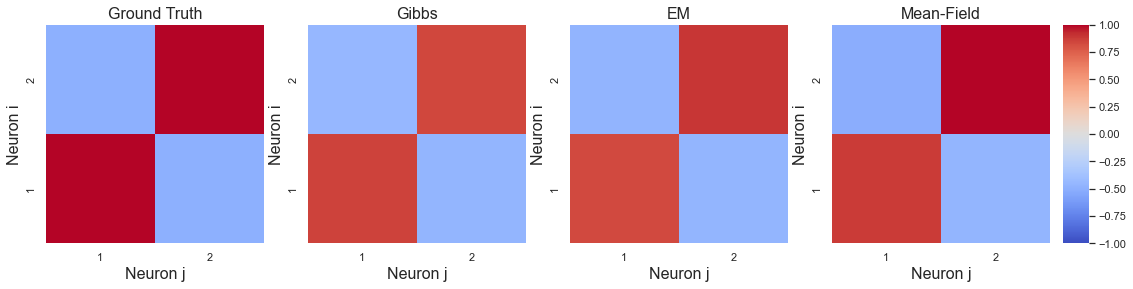

In [47]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18,7.5))
cbar_ax = fig.add_axes([.91, 0.3, .02, .405])
sns.heatmap(phi_heat_gt,ax=ax1,center=0,vmin=-1,vmax=1,square=True,xticklabels=[1,2],yticklabels=[1,2],cmap='coolwarm',cbar_ax=cbar_ax)
sns.heatmap(phi_heat_gibbs,ax=ax2, center=0,vmin=-1,vmax=1,square=True,xticklabels=[1,2],yticklabels=[1,2],cmap='coolwarm',cbar_ax=cbar_ax)
sns.heatmap(phi_heat_em,ax=ax3, center=0,vmin=-1,vmax=1,square=True,xticklabels=[1,2],yticklabels=[1,2],cmap='coolwarm',cbar_ax=cbar_ax)
sns.heatmap(phi_heat_mf,ax=ax4, center=0,vmin=-1,vmax=1,square=True,xticklabels=[1,2],yticklabels=[1,2],cmap='coolwarm',cbar_ax=cbar_ax)
ax1.set(xticklabels=[1,2],yticklabels=[1,2])
ax2.set(xticklabels=[1,2],yticklabels=[1,2])
ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()
ax4.invert_yaxis()
ax1.set_xlabel('Neuron j',fontsize=16)
ax1.set_ylabel('Neuron i',fontsize=16)
ax2.set_xlabel('Neuron j',fontsize=16)
ax2.set_ylabel('Neuron i',fontsize=16)
ax3.set_xlabel('Neuron j',fontsize=16)
ax3.set_ylabel('Neuron i',fontsize=16)
ax4.set_xlabel('Neuron j',fontsize=16)
ax4.set_ylabel('Neuron i',fontsize=16)
ax1.set_title('Ground Truth',fontsize=16)
ax2.set_title('Gibbs', fontsize=16)
ax3.set_title('EM',fontsize=16)
ax4.set_title('Mean-Field', fontsize=16)
plt.show()

Let us visualize 100 posterior samples and MAP estimate of intensity upper bounds and base activations from three inference algorithms. 

In [54]:
lamda_1_2_gibbs=pd.DataFrame(np.array(lamda_ub_list_gibbs)[-100:],columns=['$\hat{\overline{\lambda}}_1$','$\hat{\overline{\lambda}}_2$'])
lamda_1_2_gibbs['Algorithm']='Gibbs'
lamda_1_2_mf=pd.DataFrame(lamda_up_mf_samples,columns=['$\hat{\overline{\lambda}}_1$','$\hat{\overline{\lambda}}_2$'])
lamda_1_2_mf['Algorithm']='Mean-Field'
lamda_1_2=pd.concat([lamda_1_2_gibbs,lamda_1_2_mf],ignore_index=True)

In [55]:
mu_1_2_gibbs=pd.DataFrame(np.array(W_list_gibbs)[-100:,:,0],columns=['$\hat{\mu}_1$','$\hat{\mu}_2$'])
mu_1_2_gibbs['Algorithm']='Gibbs'
mu_1_2_mf=pd.DataFrame(W_mf_samples[:,:,0],columns=['$\hat{\mu}_1$','$\hat{\mu}_2$'])
mu_1_2_mf['Algorithm']='Mean-Field'
mu_1_2=pd.concat([mu_1_2_gibbs,mu_1_2_mf],ignore_index=True)

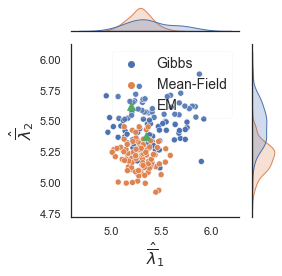

In [60]:
sns.set(style='white')
figure=sns.jointplot(data=lamda_1_2, x='$\hat{\overline{\lambda}}_1$', y='$\hat{\overline{\lambda}}_2$',hue='Algorithm',height=4)
figure.ax_joint.scatter(lamda_ub_em[0],lamda_ub_em[1],marker='^',s=60,c=np.array([sns.color_palette()[2]]),label='EM')
figure.ax_joint.legend(fontsize=14,framealpha=0.1,loc='upper right')
figure.ax_joint.set_xlabel('$\hat{\overline{\lambda}}_1$',fontsize=16)
figure.ax_joint.set_ylabel('$\hat{\overline{\lambda}}_2$',fontsize=16)
plt.tight_layout()
plt.show()

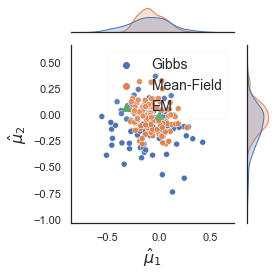

In [61]:
sns.set(style='white')
figure=sns.jointplot(data=mu_1_2, x='$\hat{\mu}_1$', y='$\hat{\mu}_2$',hue='Algorithm',height=4)
figure.ax_joint.scatter(W_em[0][0],W_em[1][0],marker='^',s=60,c=np.array([sns.color_palette()[2]]),label='EM')
figure.ax_joint.legend(fontsize=14,framealpha=0.1,loc='upper right')
figure.ax_joint.set_xlabel('$\hat{\mu}_1$',fontsize=16)
figure.ax_joint.set_ylabel('$\hat{\mu}_2$',fontsize=16)
plt.tight_layout()
plt.show()